# Лабораторная №4. Снижение размерности признакового пространства методом главных факторов.

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats as ss
import seaborn as sns

from math import  sin, cos, pi 
from statsmodels.formula.api import ols
from scipy.stats import chi2
from numpy import arange

### Считывание данных

In [2]:
features =["X7", "X15", "X17", "X23", "X27"] 
#features =["X6", "X16", "X26", "X31", "X39"] 
f_len = len (features)
unclr_data = pd.read_excel (r'C:\Games\Ekonometrika\data_for_3_and_4.xlsx').loc[:,features]
unclr_data.head()

,X7,X15,X17,X23,X27
Абдулинский,19.8,0.3,5.7,24.9,25.0
Адамовский,14.3,2.3,7.7,19.9,69.6
Акбулакский,4.5,0.5,6.8,17.4,37.8
Александровский,4.2,3.8,6.9,18.9,94.2
Асекеевский,3.5,1.7,7.7,20.4,37.3


In [3]:
unsc_data = unclr_data[unclr_data!='-'].dropna().astype('float64') # для которых нет значений, удаляем, потом стандартизуем
index = unsc_data.index #записываем в переменную index названия строк исходной матрицы
columns = unsc_data.columns #записываем в переменную columns названия столбцов исходной матрицы

index = unsc_data.index
columns = unsc_data.columns

scaled = (unsc_data - unsc_data.mean(axis=0))/unsc_data.std()
data = pd.DataFrame(scaled, columns=columns, index=index) 

data.head()

,X7,X15,X17,X23,X27
Абдулинский,1.655966,-0.969221,-1.870407,2.342609,-1.977346
Адамовский,0.797083,-0.168634,-0.205461,-0.329785,0.313800
Акбулакский,-0.733290,-0.889162,-0.954687,-1.665981,-1.319798
Александровский,-0.780138,0.431806,-0.871440,-0.864263,1.577527
Асекеевский,-0.889451,-0.408810,-0.205461,-0.062545,-1.345483


### Рассчитаем оценку корреляционной матрицы и проверим ее на значимость.

In [4]:
correlations = data.corr()
correlations

,X7,X15,X17,X23,X27
X7,1.000000,-0.278069,-0.219503,0.351428,-0.377511
X15,-0.278069,1.000000,-0.105018,-0.142029,0.258800
X17,-0.219503,-0.105018,1.000000,-0.052014,0.291052
X23,0.351428,-0.142029,-0.052014,1.000000,-0.167727
X27,-0.377511,0.258800,0.291052,-0.167727,1.000000


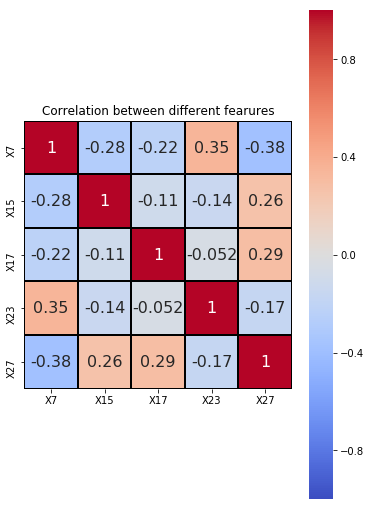

In [5]:
plt.figure(figsize=(6,9))
sns.heatmap(correlations, vmax=1,vmin=-1, center=0, square=True,annot=True,cmap='coolwarm',annot_kws={"size": 16}, 
            linewidths=1, linecolor='black')
plt.title('Correlation between different fearures')
plt.show()

Далее согласно алгоритму, предполагая, что выборка извлечена из нормально распределенной генеральной совокупности, на уровне значимости α = 0,05 проверим гипотезу о незначимости корреляционной матрицы.

In [6]:
def chi_2(n,k,R):
    return -(n-1/6*(2*k+5))*math.log(np.linalg.det(R), math.e)

chi_2_crt=chi_2(data.shape[0],data.shape[1],correlations)
print('Наблюдаемое значение составило',chi_2_crt)
p_value=chi2.sf(chi_2_crt, data.shape[1]*(data.shape[1]-1)/2)
print ('Значение p-value равно {}'.format(p_value))
if p_value>0.05:
    print('Принимаем гипотезу, матрица парных коэффициентов корреляции незначима')
else:
    print('Отвергаем гипотезу, матрица парных коэффициентов корреляции значима')

Наблюдаемое значение составило 24.800958503757464
Значение p-value равно 0.0057358254797657705
Отвергаем гипотезу, матрица парных коэффициентов корреляции значима


# Снижение размерности методом главных компонент.

## Рассчитаем оценки собственных чисел корреляционной матрицы.

In [7]:
uns_eigenvalues,eigenvectors=np.linalg.eig(correlations)
couple_lst=[]
for i in range(len(uns_eigenvalues)):
    couple_lst.append((uns_eigenvalues[i],eigenvectors[:,i]))
    
from operator import itemgetter
couple_lst = sorted(couple_lst, key = itemgetter(0),reverse=True)
#список со значениями оценок собственных чисел (eigenvalues), расположенных по убыванию
eigenvalues=sorted(uns_eigenvalues,reverse=True)

In [8]:
pd.DataFrame(eigenvalues, index=list(range(1,f_len+1)), columns = ['eigenvalues'])

,eigenvalues
1,1.883631
2,1.124561
3,0.887302
4,0.568365
5,0.536142


## Доверительные интервалы для собственных значений

С вероятностью γ=0,95 построим доверительные интервалы для собственных чисел матрицы парных коэффициентов корреляции.
Доверительный интервал для i-ого собственного числа λi при большом объеме выборки имеет вид:

$$ \frac {\hat \lambda_i}{1 +  u_{\frac {1+\gamma} {2}} \sqrt {\frac {2}{n-1}} } < \lambda_i < \frac {\hat \lambda_i}{1 -  u_{\frac {1+\gamma} {2}} \sqrt {\frac {2}{n-1}} } $$ 

где $ u_{\frac {1+\gamma} {2}} $ – квантиль уровня $ \frac {1+\gamma}{2} $ стандартного нормального распределения
<br>
n – объем выборки.

In [9]:
def eigenval_left(l,n):
    return l/(1+ss.norm.ppf(0.975)*math.sqrt(2/(n-1))) #находим нижнюю границу интервала

def eigenval_right(l,n):
    return l/(1-ss.norm.ppf(0.975)*math.sqrt(2/(n-1))) #находим верхнюю границу интервала

conf_interval=np.empty((5, 3)) # создание матрицы для каждого из значений интервала и соответствующего ему собственного числа
for i in range(conf_interval.shape[0]):
    conf_interval[i,0]=eigenval_left(eigenvalues[i],data.shape[0])
    conf_interval[i,1]=eigenvalues[i]
    conf_interval[i,2]=eigenval_right(eigenvalues[i],data.shape[0])
    
conf_interval_df=pd.DataFrame(
    conf_interval,
    columns=['Нижняя граница','Собственное значение','Верхняя граница'])
conf_interval_df

,Нижняя граница,Собственное значение,Верхняя граница
0,1.337160,1.883631,3.185473
1,0.798308,1.124561,1.901782
2,0.629881,0.887302,1.500546
3,0.403473,0.568365,0.961181
4,0.380599,0.536142,0.906688


Так как оценки собственных чисел не попадают в доверительные интервалы других собственных чисел, то нет оснований заподозрить кратность собственных чисел.

## Определение количества ГК

Рассчтаем вклад главных компонент в суммарную дисперсию исходных признаков.

In [10]:
dispersion=np.zeros(len(eigenvalues))
for i in range(dispersion.shape[0]):
    dispersion[i]=eigenvalues[i]/uns_eigenvalues.sum()

In [11]:
cumlt_dispersion = np.zeros(f_len)
cur=0
for i in range(len(features)):
    cur=cur+dispersion[i]
    cumlt_dispersion[i]=cur

In [12]:
cumlt=np.zeros(f_len)
cur=0
for i in range(len(features)):
    cur=cur+eigenvalues[i]
    cumlt[i]=cur

In [13]:
d=np.array([eigenvalues,dispersion,cumlt,cumlt_dispersion]).T
s=pd.DataFrame(
    data=d,
    columns=['eig','variance','cumlt_eig','cumlt_variance'])
s

,eig,variance,cumlt_eig,cumlt_variance
0,1.883631,0.376726,1.883631,0.376726
1,1.124561,0.224912,3.008192,0.601638
2,0.887302,0.177460,3.895493,0.779099
3,0.568365,0.113673,4.463858,0.892772
4,0.536142,0.107228,5.000000,1.000000


In [14]:
#нижняя граница уровня информативности
low_inf = (conf_interval[0,0] + conf_interval[1,0])*100/5
print ('Нижняя граница уровня информативности:',"%5.2f"%(low_inf)+'%')

Нижняя граница уровня информативности: 42.71%


### Критерий Кайзера

Посмотрим, сколько главных компонент предлагает взять критерий Кайзера.

In [15]:
print(('Критерий Кайзера предлагает {} ГК.').format(len(s.eig[s.eig > 1])))

Критерий Кайзера предлагает 2 ГК.


### Критерий каменистой осыпи

Построим график собственных чисел корреляционной матрицы.

In [16]:
sum_lmbd=uns_eigenvalues.sum()
dft = pd.DataFrame([])
dft['y'] = eigenvalues #собственные значения в порядке убывания
dft['x'] = list(range(1,f_len+1))
dft['Tot_var'] = (dft['y']/sum_lmbd).apply(lambda x: round(x * 100, 2)).apply(str) + '%' #относительный вклад каждой 
#главной компоненты в суммарную дисперсию

In [17]:
dft

,y,x,Tot_var
0,1.883631,1,37.67%
1,1.124561,2,22.49%
2,0.887302,3,17.75%
3,0.568365,4,11.37%
4,0.536142,5,10.72%


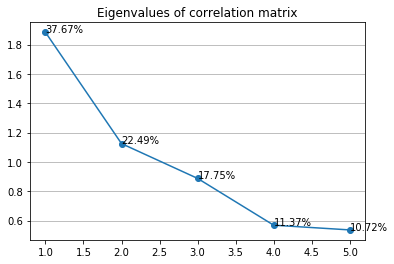

In [18]:
#plt.figure(figsize=(9,6))
plt.plot(dft['x'], dft['y'], marker='o')
ax = plt.gca()
dft.apply(lambda x: ax.annotate(x['Tot_var'], (x['x'], x['y'])), axis=1);
plt.title('Eigenvalues of correlation matrix')
plt.grid(axis='y')
plt.show()

Выбираем количество главных компонент на основе критериев

In [19]:
pc = 3

## Матрица U

Матрица коэффициентов линейного преобразования имеет вид:

In [20]:
u=np.empty((f_len,f_len))
for i in range(f_len):
    u[i]=couple_lst[i][1] #достаем главные компоненты(собственные векторы корреляционной матрицы) из матрицы couple_list
    
#pd.DataFrame(u)

In [21]:
df_u=pd.DataFrame(
    data=u,
    index=['Factor_' + str(i + 1) for i in range(f_len)],
    columns=features)
df_u # eigenvectors of correlation matrix
# ВНИМАНИЕ !!!!!
#Она не сходится со статистикой !!! Но правильная именно в питоне ( в статистике матрица не нормирована, см. методичку) !!!

,X7,X15,X17,X23,X27
Factor_1,-0.576686,0.366244,0.297820,-0.406131,0.528828
Factor_2,0.032425,-0.588337,0.760574,0.209045,0.175029
Factor_3,-0.133058,-0.469677,-0.053971,-0.779764,-0.388272
Factor_4,0.525319,-0.247440,-0.301702,-0.271192,0.705864
Factor_5,0.610506,0.487752,0.488767,-0.331332,-0.201758


Главные компоненты связаны с центрировано-нормированными исходными признаками следующими линейными комбинациями:

In [22]:
for i in range(0,pc):
    print(('Z{:1} = '+'{:2.3f}*X{:1} + '*4+'{:2.3f}*X{:1}').format(i+1,u[i][0],1,u[i][1],2,u[i][2],3,u[i][3],4,u[i][4],5))

Z1 = -0.577*X1 + 0.366*X2 + 0.298*X3 + -0.406*X4 + 0.529*X5
Z2 = 0.032*X1 + -0.588*X2 + 0.761*X3 + 0.209*X4 + 0.175*X5
Z3 = -0.133*X1 + -0.470*X2 + -0.054*X3 + -0.780*X4 + -0.388*X5


## Матрица нагрузок А

Рассчитаем матрицу нагрузок.

In [23]:
#матрица нагрузок
lmbd = np.zeros((f_len,f_len))
for i in range(f_len):
    lmbd[i][i]= math.sqrt(eigenvalues[i])
            
A = np.dot(u.T, lmbd)
df_A = pd.DataFrame(data=A,columns=['Factor_' + str(i + 1) for i in range(f_len)],index=features)
df_A

,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5
X7,-0.791475,0.034385,-0.125337,0.396038,0.447023
X15,0.502654,-0.623903,-0.442420,-0.186545,0.357140
X17,0.408744,0.806553,-0.050839,-0.227453,0.357884
X23,-0.557397,0.221683,-0.734511,-0.204452,-0.242607
X27,0.725793,0.185610,-0.365739,0.532151,-0.147731


In [24]:
# Могут не совпасть отдельные столбики со Statistica, так как собственные вектора берутся с точностью до знака
# Если очень хочется подогнать, можно написать:
#df_A['Factor_1'] *= -1  # если не совпал первый столбик
#df_A['Factor_2'] *= -1  # если не совпал второй столбик
#df_A['Factor_3'] *= -1  # если не совпал третий столбик
#df_A['Factor_4'] *= -1  #если не совпал четвертый столбик
#df_A['Factor_5'] *= -1  #если не совпал пятый столбик
#df_A#проверить, сходится ли теперь

Так как размерность признакового пространства снижена до двух, то матрица факторных нагрузок имеет размерность 5х2.

In [25]:
df_A_cut = pd.DataFrame(data=A[:,:pc],columns=['Factor_' + str(i) for i in range(1,pc+1)],index=features)
df_A_cut

,Factor_1,Factor_2,Factor_3
X7,-0.791475,0.034385,-0.125337
X15,0.502654,-0.623903,-0.442420
X17,0.408744,0.806553,-0.050839
X23,-0.557397,0.221683,-0.734511
X27,0.725793,0.185610,-0.365739


Получим расположение признаков в пространстве первых двух главных компонент.
Если вы вдруг взяли 3 главные компоненты, то тут можно получать сравненение только по двум координатам,
меняя в 'Factor_' цифры
Трехмерное изображение не предусмотрено

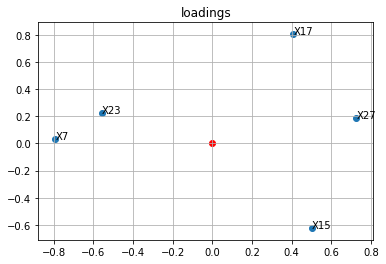

In [26]:
#plt.figure(figsize=(9,6))
plt.scatter(df_A_cut['Factor_1'], df_A_cut['Factor_2'])
plt.scatter (0,0,c = 'r')
for i in features:
    plt.annotate('{}'.format(i), xy=(df_A_cut['Factor_1'][i], df_A_cut['Factor_2'][i]))
plt.title('loadings')
plt.grid()
plt.show()

Центрировано-нормированные исходные признаки связаны с центрировано-нормированными главными компонентами следующими выражениями:

In [27]:
for i in range(0,f_len):
    print(('X{:1} = '+'{:2.3f}*F{:1} + {:2.3f}*F{:1} + {:2.3f}*F{:1}').format(i+1,A[i][0],1,A[i][1],2,A[i][2],3))

X1 = -0.791*F1 + 0.034*F2 + -0.125*F3
X2 = 0.503*F1 + -0.624*F2 + -0.442*F3
X3 = 0.409*F1 + 0.807*F2 + -0.051*F3
X4 = -0.557*F1 + 0.222*F2 + -0.735*F3
X5 = 0.726*F1 + 0.186*F2 + -0.366*F3


## Расчет индивидуальных значений (матрица F)

Рассчитаем матрицу индивидуальных значений центрировано-нормированных главных компонент.

In [28]:
F=np.dot(np.dot(np.linalg.inv(np.dot(A[:,:pc].T,A[:,:pc])),A[:,:pc].T),data.T)
df_F = pd.DataFrame(data=F.T, columns=['Factor'+str(i) for i in range(1,pc+1)], index=data.index).head()
df_F

,Factor1,Factor2,Factor3
Абдулинский,-2.815446,-0.617699,-0.767654
Адамовский,-0.206008,-0.042647,0.126913
Акбулакский,-0.151871,-0.760080,2.524746
Александровский,1.117527,-0.798429,0.010020
Асекеевский,-0.279870,-0.182153,0.947624


# Снижение размерности признакового пространства методом главных факторов

## Оценки общностей и ОЦЕНКА редуцированной матрицы

### Оценки общностей

Оценками общностей будут служить квадраты оценок множественных коэффициентов корреляции.

In [29]:
communalities=[]
for variable in features:
    communalities.append(ols(formula="{} ~ {}".format(variable, ' + '.join(set(features)-set([variable]))),
                             data=data).fit().rsquared)

In [30]:
pd.DataFrame(communalities,index = features,columns = ['Communalities']) # это те самые множественные коэффициенты корреляции, которые являются оценками общностей

,Communalities
X7,0.274396
X15,0.151881
X17,0.145664
X23,0.127281
X27,0.229682


### Оценка матрицы Rh

На основе оценки матрицы парных коэффициентов корреляции и оценок общностей можно составить ОЦЕНКУ редуцированной матрицы R<sub><small>h</small></sub>.

In [31]:
Rh_eval = np.empty((f_len,f_len)) # оценка матрицы Rh - она как R, но на диагоналях оценки общностей
for i in range (f_len):
    for j in range (f_len):
        if i==j:
            Rh_eval[i][j] = communalities[i]
        else:
            Rh_eval[i][j] = correlations.values [i][j]
            
pd.DataFrame(Rh_eval, index=features, columns=features)

,X7,X15,X17,X23,X27
X7,0.274396,-0.278069,-0.219503,0.351428,-0.377511
X15,-0.278069,0.151881,-0.105018,-0.142029,0.258800
X17,-0.219503,-0.105018,0.145664,-0.052014,0.291052
X23,0.351428,-0.142029,-0.052014,0.127281,-0.167727
X27,-0.377511,0.258800,0.291052,-0.167727,0.229682


## Выбор количества факторов

Рассчитаем оценку собственных чисел оцененной матрицы R<sub><small>h</small></sub>.

In [32]:
uns_eigenvalues_Rh_eval,eigenvectors_Rh_eval=np.linalg.eig(Rh_eval)
couple_lst=[]
for i in range(len(uns_eigenvalues_Rh_eval)): # список по убыванию сз с соответствующими св
    couple_lst.append((uns_eigenvalues_Rh_eval[i],eigenvectors_Rh_eval[:,i]))
    
from operator import itemgetter
couple_lst = sorted(couple_lst, key = itemgetter(0),reverse=True)
#значениями оценок собственных чисел (eigenvalues), расположенных по убыванию
eigenvalues_Rh_eval=sorted(uns_eigenvalues_Rh_eval,reverse=True)


Выведем собственные значения и соответсвующие им собственые вектора оцененной матрицы R<sub><small>h</small></sub>.

In [33]:
couple_lst

[(1.0959859136797714,
  array([-0.6034735 ,  0.35006797,  0.28585428, -0.37856324,  0.53688859])),
 (0.27471085818793256,
  array([ 0.05430905, -0.59266597,  0.74978205,  0.21139014,  0.19732879])),
 (0.04346216615482449,
  array([0.23919042, 0.45709624, 0.01866845, 0.71788468, 0.46705894])),
 (-0.20554761794181142,
  array([-0.66685459,  0.09973086,  0.12551297,  0.49965772, -0.52910052])),
 (-0.27970824190529636,
  array([ 0.36188832,  0.55436111,  0.58310564, -0.21676678, -0.41799591]))]

### Сравнение общности с суммой лямбд

In [34]:
print('Суммарная общность: ', np.trace(Rh_eval))
print('Сумма оценок первых двух собственных чисел редуцированной матрицы:', eigenvalues_Rh_eval[0]+eigenvalues_Rh_eval[1])
if  np.trace(Rh_eval) < eigenvalues_Rh_eval[0]+eigenvalues_Rh_eval[1]:
    print('Размерность признакового пространства можно снизить до двух общих факторов.')
else:
    print ('До двух факторов снизить нельзя')

Суммарная общность:  0.9289030781754185
Сумма оценок первых двух собственных чисел редуцированной матрицы: 1.370696771867704
Размерность признакового пространства можно снизить до двух общих факторов.


### Критерий каменистой осыпи

In [35]:
dft = pd.DataFrame([])
eigenvalues_pos=[]
for i in range (len(eigenvalues_Rh_eval)):
    if eigenvalues_Rh_eval[i] >= 0:
        eigenvalues_pos.append(eigenvalues_Rh_eval[i])
dft['y'] = eigenvalues_pos
dft['x'] = list (range(len(eigenvalues_pos)))
dft['Tot_var'] = (dft['y']/f_len).apply(lambda x: round(x * 100, 2)).apply(str) + '%'
dft

,y,x,Tot_var
0,1.095986,0,21.92%
1,0.274711,1,5.49%
2,0.043462,2,0.87%


Построим график собственных чисел (положительных).

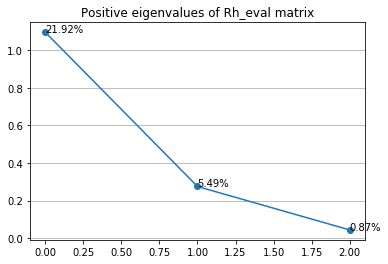

In [36]:
plt.figure(figsize=(6,4))
plt.plot(dft['x'], dft['y'], marker='o')
ax = plt.gca()
dft.apply(lambda x: ax.annotate(x['Tot_var'], (x['x'], x['y'])), axis=1)
plt.title('Positive eigenvalues of Rh_eval matrix')
plt.grid(axis='y')
plt.show()

### Критерий Кайзера

Посмотрим, сколько факторов предлагает брать критерий Кайзера.

In [37]:
print('Критерий Кайзера предлагает {} фактор(-а/ов).'
      .format(len(uns_eigenvalues_Rh_eval[uns_eigenvalues_Rh_eval > 1])))

Критерий Кайзера предлагает 1 фактор(-а/ов).


### Итоговое решение (на самом деле придется всегда брать 2)

Установим число факторов равное двум.

In [38]:
fact = 2

## матрица U

Рассчитаем матрицу U.

In [39]:
U = np.empty ((fact,f_len)) # матрица U (у неё по строкам собств. вектора, соотв. положительным значениям РЕДУЦИРОВАННОЙ МАТРИЦЫ (уточнить у Домашовой))
for i in range(fact):
    U[i]=couple_lst[i][1]
    
df_U=pd.DataFrame( # обертка в датафрейм
    data=U,
    index=['Factor_' + str(i + 1) for i in range(fact)],
    columns=features)
df_U

,X7,X15,X17,X23,X27
Factor_1,-0.603474,0.350068,0.285854,-0.378563,0.536889
Factor_2,0.054309,-0.592666,0.749782,0.211390,0.197329


### Матрица нагрузок A

Рассчитаем матрицу нагрузок.

In [40]:
sqrt_l=np.eye(fact)
for i in range(fact):
    sqrt_l[i][i]=math.sqrt(eigenvalues_Rh_eval[i])  
A=np.dot(U.T,sqrt_l)
df_A = pd.DataFrame(
    data=A,
    columns=['Factor_' + str(i + 1) for i in range(fact)],
    index=features)
df_A # на этом этапе матрица может не совпасть со statistica во всех знаках 1-ого или 2-ого столбца (или в обоих)
# Это НЕ ОШИБКА, так как собственные вектора матрицы U (а по ней по сути и строится А) берутся с точностью до знака

,Factor_1,Factor_2
X7,-0.631772,0.028465
X15,0.366484,-0.310633
X17,0.299259,0.392982
X23,-0.396315,0.110796
X27,0.562065,0.103426


Если очень хочется подогнать под statistica, то можно написать:

In [41]:
#df_A['Factor_1'] *= -1  # если не совпал первый столбец

In [42]:
#df_A['Factor_2'] *= -1 #   если не совпал второй столбец

In [43]:
#df_A # проверить, совпадает ли теперь

Построим расположение исходных признаков на плоскости, образованной двумя главными факторами.

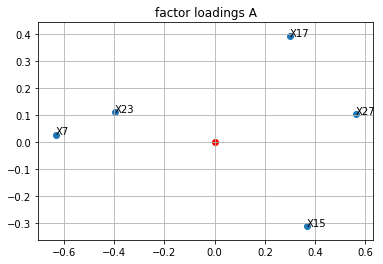

In [44]:
plt.scatter(df_A['Factor_1'],df_A['Factor_2'])
plt.scatter (0,0,c = 'r') # чтобы было видно, относительно чего потом будем поворачивать
plt.grid()
plt.title ('factor loadings A')
for variable in features :
    plt.annotate('{}'.format(variable),xy = (df_A['Factor_1'][variable],df_A['Factor_2'][variable]))

## Вращение факторов

In [45]:
_ = \
'''
задумка, чтобы максимально подогнать под статистику

Будем осуществлять повороты на углы от 0 до pi/2 с очень маленьким шагом и считать квартимакс(варимакс) 
для каждого угла
По максимальному квартимаксу(варимаксу) отбираем соответствующую матрицу B
'''

In [46]:
def quartimax (X): # ФУНКЦИИ ДЛЯ ВЫБОРА И  РАСЧЕТА КРИТЕРИЯ
    value = 0
    m = X.shape[1]
    for row in X:
        value += (sum (row**4) - (sum(row**2))**2)/m**2
    return value

def varimax (X) :
    value = 0
    k = X.shape[0]
    for row in X.T:
        value += (k*sum(row**4) - sum(row**2)**2)/k**2
    return value
    
def criteria (method,X):
    if method == 'varimax':
        return varimax(X)
    elif method == 'quartimax':
        return quartimax (X)
    else :
        print ('wrong input')

In [47]:
rad_column = [] # это список, в который будут складываться углы в радианах
grad_column=[] # это список, в который будут складывать углы в градусах

criteria_column = [] # это список, в который будут складываться квартимаксы
dict_for_B = {} # это словарь, где ключами будут квартимаксы, а значениями - матрицы

for alpha in arange (0,pi/2,0.0001): # Проходим от 0 до pi/2 с шагом 0.0001
    
    rad_column.append(alpha)
    grad_column.append(alpha*180/pi)
    
    grad = alpha
    T = [[cos(grad),sin(grad)],
         [-sin(grad),cos(grad)]]
    B = np.dot (A,T)
    dict_for_B[criteria('quartimax',B)] = B # здесь пишем метод, который мы хотим
    criteria_column.append (criteria('quartimax',B)) # и здесь тоже

In [48]:
df_rotation = pd.DataFrame([]) # дата фрейм, в который мы положим заполненные списки
df_rotation['rad'] = rad_column
df_rotation['grad'] = grad_column
df_rotation ['criteria'] = criteria_column
#df_rotation # это по сути и есть та самая сетка

### Максимальное значение критерия

In [49]:
criteria_best = df_rotation ['criteria'].max() # ищем максимальное значение критерия
criteria_best

-0.016012823514628398

### Лучший угол для вращения

In [50]:
rad_best = df_rotation.loc[df_rotation['criteria'].idxmax(),'rad']# вывод лучшего угла
grad_best = df_rotation.loc [df_rotation['criteria'].idxmax(),'grad']
print ('Лучший угол для вращения :{:.3f} радиан или {:.3f} градусов'.format (rad_best,grad_best)) 

Лучший угол для вращения :0.051 радиан или 2.928 градусов


### Матрица B 

Весовые коэффициенты факторов после вращения:

In [51]:
B = dict_for_B [criteria_best] # вывод лучшей матрицы
df_B = pd.DataFrame(data=B, columns=['Factor_' + str(i + 1) for i in range(fact)], index=features)
df_B

,Factor_1,Factor_2
X7,-0.632402,-0.003842
X15,0.381872,-0.291509
X17,0.278796,0.407755
X23,-0.401457,0.090408
X27,0.556049,0.132000


In [52]:
_ = \
'''
Результат может не сходиться со statistica (могут не совпадать все знаки в столбце(-цах), 
а также в statistica может быть другой порядок столбцов (или всё вместе))
Это НЕ ОШИБКА, так как данное несоответствие обуславливается тем, что: 
 a) Могло быть несоответствие в матрице A и его не поправляли
 б) Угол поворота в statistica был не в интервале [0;pi/2]
Если очень хочется подогнать под статистику,то:
1)подгоните матрицу A (если надо) 
2)попробуйте поменять промежуток в цикле на :

2a)[pi/2 ; pi]  в случае, если столбцы  поменялись местами и не совпадает знак ПЕРВОГО столбца в полученной матрице
2б) [pi;3*pi/2] в случае если столбцы на месте, но отличаются АБСОЛЮТНО ВСЕ ЗНАКИ
2в) [3*pi/2;2*pi] в случае если столбцы поменялись местами и не совпадает знак ВТОРОГО столбца в полученной матрице

Если у вас матрица B не сходится со статистикой и при этом не подходит ни одному из случаев, то вы либо
не подогнали A, либо накосячили ещё где-то )))

'''

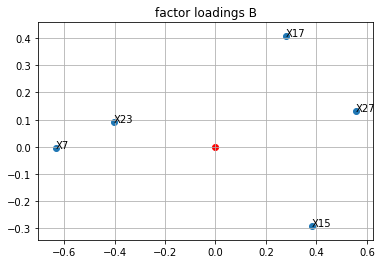

In [53]:
plt.scatter(df_B['Factor_1'],df_B['Factor_2'])
plt.scatter (0,0,c= 'r')
plt.grid()
plt.title ('factor loadings B')
for variable in features :
    plt.annotate('{}'.format(variable),xy = (df_B['Factor_1'][variable],df_B['Factor_2'][variable]))
    #график может не совпасть со statistica по описанным ранее причинам

### Теперь сравниваем два графика (две матрицы) A и B и решаем, помогло ли вращение.Если НЕ помогло, то следует снять комментарий и прораннить следующую строчку:

In [54]:
#B = A

## Rh, D2, значения характерностей

Рассчитаем характерности. Для этого нам необходимо получить матрицы R<sub><small>h</small></sub> (оценка редуцированной матрицы) и D<sup>2</sup> (оценка остаточной матрицы парных коэффициентов корреляции).

In [55]:
Rh_real = np.dot(B,B.T)
pd.DataFrame(Rh_real,index = features,columns = features) # в statistica это reproduced corr

,X7,X15,X17,X23,X27
X7,0.399947,-0.240377,-0.177877,0.253535,-0.352153
X15,-0.240377,0.230803,-0.012400,-0.179660,0.173860
X17,-0.177877,-0.012400,0.243991,-0.075060,0.208847
X23,0.253535,-0.179660,-0.075060,0.169342,-0.211296
X27,-0.352153,0.173860,0.208847,-0.211296,0.326614


In [56]:
D2 = correlations.values - Rh_real
pd.DataFrame(D2,index = features,columns = features) # в statistica это residual corr

,X7,X15,X17,X23,X27
X7,0.600053,-0.037692,-0.041626,0.097893,-0.025358
X15,-0.037692,0.769197,-0.092618,0.037631,0.084939
X17,-0.041626,-0.092618,0.756009,0.023046,0.082204
X23,0.097893,0.037631,0.023046,0.830658,0.043569
X27,-0.025358,0.084939,0.082204,0.043569,0.673386


In [57]:
charact =[]
for i in range(D2.shape[0]):
    charact.append (math.sqrt(D2[i][i]))
    
charact

[0.7746310775133721,
 0.8770385231556297,
 0.8694877812833258,
 0.9114046576009538,
 0.8206009377803851]

In [58]:
for i in range(0,f_len):
    print('X{} = {:.3f}*F{} + {:.3f}*F{} + {:.3f}*D{}'.format(i+1,B[i,0],1,B[i,1],2,charact[i],i+1))

X1 = -0.632*F1 + -0.004*F2 + 0.775*D1
X2 = 0.382*F1 + -0.292*F2 + 0.877*D2
X3 = 0.279*F1 + 0.408*F2 + 0.869*D3
X4 = -0.401*F1 + 0.090*F2 + 0.911*D4
X5 = 0.556*F1 + 0.132*F2 + 0.821*D5


## Матрица индивидуальных значений обобщенных факторов (как считает Statistica)

In [59]:
factor_score_coefficients = np.dot(np.linalg.inv(correlations),B)
factor_score_coefficients 

array([[-0.37583147,  0.013227  ],
       [ 0.18562557, -0.26932923],
       [ 0.11868953,  0.35233547],
       [-0.18647231,  0.08571307],
       [ 0.30030725,  0.1185239 ]])

In [60]:
factor_scores = np.dot (data.values,factor_score_coefficients)
df_factor_scores_stat = pd.DataFrame (data = factor_scores,index = index , columns = ['Factor1_stat','Factor2_stat'])
df_factor_scores_stat # если в матрицах A или B были несовпадения со статистикой по знаку или в порядке столбцов
# и вы их не исправляли, то они  иначе отобразятся и здесь
# НО ЭТО НЕ ОШИБКА

,Factor1_stat,Factor2_stat
Абдулинский,-2.054917,-0.409638
Адамовский,-0.199526,-0.007504
Акбулакский,-0.088454,-0.405816
Александровский,0.904828,-0.320760
Асекеевский,-0.158384,-0.138884
Беляевский,-0.012638,-0.221573
Бугурусланский,-0.440321,0.290030
Бузулукский,-0.220042,0.964909
Гайский,-1.330736,-1.015071
Грачевский,-0.132164,0.332254


 ### Значения факторов (по формулам из лекции)

In [61]:
Q = np.linalg.inv(np.dot(np.dot(B.T,np.linalg.inv(D2)),B)) # первый множитель в той длинной формуле (чтоб не нагромождать)
W = np.dot(np.dot (B.T,np.linalg.inv(D2)),data.values.T) # второй множитель 
F = np.dot (Q,W)
df_factor_scores_lect = pd.DataFrame (data =F.T,index = index, columns = ['Factor1_lect','Factor2_lect'] )
df_factor_scores_lect

,Factor1_lect,Factor2_lect
Абдулинский,-3.477110,-1.406292
Адамовский,-0.341795,-0.004796
Акбулакский,-0.099397,-1.645378
Александровский,1.595958,-1.426765
Асекеевский,-0.254101,-0.546513
Беляевский,0.006987,-0.902986
Бугурусланский,-0.793996,1.241143
Бузулукский,-0.502985,3.967958
Гайский,-2.154616,-3.971903
Грачевский,-0.270078,1.373621


## Объединение двух датафреймов в один и выгрузка в файл

In [62]:
df_result = pd.concat([df_factor_scores_lect, df_factor_scores_stat], axis=1)
df_result

,Factor1_lect,Factor2_lect,Factor1_stat,Factor2_stat
Абдулинский,-3.477110,-1.406292,-2.054917,-0.409638
Адамовский,-0.341795,-0.004796,-0.199526,-0.007504
Акбулакский,-0.099397,-1.645378,-0.088454,-0.405816
Александровский,1.595958,-1.426765,0.904828,-0.320760
Асекеевский,-0.254101,-0.546513,-0.158384,-0.138884
Беляевский,0.006987,-0.902986,-0.012638,-0.221573
Бугурусланский,-0.793996,1.241143,-0.440321,0.290030
Бузулукский,-0.502985,3.967958,-0.220042,0.964909
Гайский,-2.154616,-3.971903,-1.330736,-1.015071
Грачевский,-0.270078,1.373621,-0.132164,0.332254


In [63]:
df_result.to_excel('4lab_result.xlsx')

PermissionError: [Errno 13] Permission denied: '4lab_result.xlsx'